In [200]:
from ib_insync import *
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
#import statsmodels
#import statsmodels.api as sm
#from statsmodels.tsa.stattools import coint, adfuller
#from statsmodels import regression,stats
import math
import datetime 
import statsmodels.formula.api as smf 
from datetime import date, time, datetime, timedelta
#from xml.etree import ElementTree as ET
#from IPython.core.debugger import set_trace
import seaborn as sns
import random
from ta import add_all_ta_features
from ta.utils import dropna
from ta.trend import *

In [202]:
# Connect to IB Server
ib=IB()
util.startLoop()
ib.connect('127.0.0.1',7497, clientId= 5955)

<IB connected to 127.0.0.1:7497 clientId=5955>

In [204]:
#define a function to get IB data. endDate is the last date of the historical data 

def get_data(contract, history, freq, side, endDate =''):
    
    bar = ib.reqHistoricalData(
        contract,
        endDateTime = endDate,
        durationStr=history,
        barSizeSetting= freq,
        whatToShow=side,
        useRTH=True,
        formatDate=1)
    
# use util in ib-insync to convert bar data into pandas dataframe    
    df = util.df(bar)
# return df 
    return df 
# find a stock contract and fully qualify it with all the attributes

history = '7 Y'
freq = '1 day'
side ='Trades' # last trade, or ASK, or Bid
endDate = '' 


ticker1 ='GOOG'
ticker2 = 'SPY'
ticker3 = 'DIA'

contract1 = Contract(symbol = ticker1, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract1)

contract2 = Contract(symbol = ticker2, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract2)

contract3 = Contract(symbol = ticker3, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract2)

df1 = get_data(contract1, history, freq, side,endDate )
df2 = get_data(contract2, history, freq, side,endDate )


In [205]:
df1.head()

,date,open,high,low,close,volume,average,barCount
0,2015-10-05,632.00,643.01,627.00,641.47,11766,636.4515,8841
1,2015-10-06,638.45,649.25,636.52,645.44,14661,642.5255,11662
2,2015-10-07,649.24,650.61,632.15,642.36,14002,639.9570,10799
3,2015-10-08,641.36,644.45,625.56,639.16,15429,634.3160,11309
4,2015-10-09,640.00,645.99,635.31,643.61,10686,642.5825,7945


In [159]:
#import ta library for indicators
from ta.momentum import *
from ta.volatility import BollingerBands

# find the indicator series 
df1['rsi']= rsi(df1.open, window =20)
df1['sma'] = sma_indicator(df1.open, window =30)
df1['smal'] = sma_indicator(df1.open, window =100)
df1['ema']= ema_indicator(df1.open, window =20)
df1['bb_h'] = BollingerBands(df1.open, window=20, window_dev=2).bollinger_hband() 
df1['bb_l'] = BollingerBands(df1.open, window=20, window_dev=2).bollinger_lband() 
df1['bb_m'] = BollingerBands(df1.open, window=20, window_dev=2).bollinger_mavg() 

#set start and end dates for backtesting. Need to be within the given history(defined above) period
startDate =date(2018,3,1)
endDate =date(2020,3,1)

#select data for the backtesting period only
df = df1[(df1.date>=startDate) & ((df1.date<=endDate))]
#reset index starting from zero for df
df.index = range(df.count()[0])

pos = 0
pos_prev=0
pnl =0

vt =[]

rsi_entry_up =70
rsi_entry_dn  = 30

capital = 100000

#we backtest two strategies together
strategy =['rsi','bb']

for ind in strategy:
# for each strategy, rsi or bb,    
    pos = 0
    pos_prev=0
    pnl =0
    capital = 100000
    
    # we move through the earliest time to the latest time, and make trading decision at each time based on rsi and bb
    
    for index, row in df.iterrows():

        #initiate the pos, and pos_prev (previous position)
        
        if index>0:
            pos_prev =  pos
            px_prev = px
            pnl = pos_prev*(row['open']-px_prev )
        \
        # If there is no position opened, that is pos =0
        
        if pos == 0:
            
            if ind == 'rsi':
                if row['rsi'] > rsi_entry_up:
                    #open a position to sell
                    pos = - round( capital /row['open'])        
                elif row['rsi'] < rsi_entry_dn:
                    #open a position to buy
                    pos =  round( capital /row['open'])
            else:
                #if it is BB strategy:
                
                if row['open']>= row['bb_h']:
                    #open position if price is above upper band:
                    pos = - round( capital /row['open']) 
                    
                elif  row['open']<= row['bb_l']:
                    pos = round( capital /row['open']) 
                    
        # if there is an open position
        else:
            # Decide on conditions for closing. For rsi, there is on closing, it is either long or short
            # for bb,when long (pos>0), exit when price drops below the median if bb, the other when short
            
            # for rsi, you always have as position either long or short, depending on the level of rsi
            if ind=='bb':
                
                if pos>0 and row['open'] >= row['bb_m']:
                    #rsi decines from upper band to lower band, exit
                    pos =0

                elif  pos <0 and row['open'] <=  row['bb_m']:
                    pos =0
                            
        # keep track of the current open price, which will become previous price at the next record.        
        px = row['open']
        
        # adjust capital position by the amount of daily pnl
        capital = capital +pnl
        #create new columns for pos, pnl, and ind
        #print (ind, pos, px, row['rsi'], row['bb_h'], row['bb_l'], row['bb_m'],row['date'])    
        df.loc[index, 'pos_'+ind] = pos
        df.loc[index, 'pnl_'+ind] = pnl
        df.loc[index, 'capital'] =capital
        df.loc[index, 'strategy'] = ind
        

C:\ProgramData\WinPython\WPy64-3850\python-3.8.5.amd64\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\WinPython\WPy64-3850\python-3.8.5.amd64\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [199]:
#export the data into a local flat file for better viewing and analysis
df['cum_rsi'] = df['pnl_rsi'].cumsum()
df['cum_bb'] = df['pnl_bb'].cumsum()
path = r"C:\Users\publi\Documents\GitHub\Duke\DukeMath590\output.csv"
df.to_csv(path)

<ipython-input-199-e56a4b320751>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cum_rsi'] = df['pnl_rsi'].cumsum()
<ipython-input-199-e56a4b320751>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cum_bb'] = df['pnl_bb'].cumsum()


<AxesSubplot:xlabel='date'>

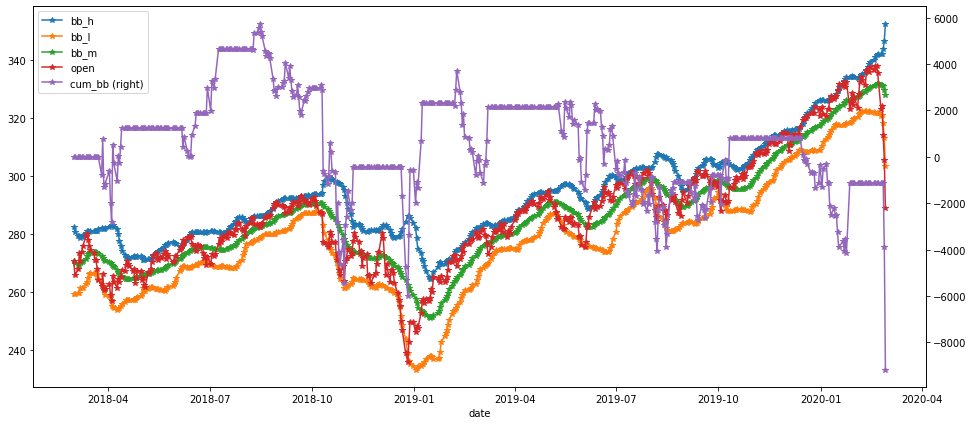

In [197]:
#Graph the Indicator, PnL and Positions

df.plot(figsize =[16,7], x='date',y=['bb_h','bb_l','bb_m','open', 'cum_bb'],secondary_y='cum_bb', marker ="*")

# you can verify if the strategy implementation is consistent with the plan

<AxesSubplot:>

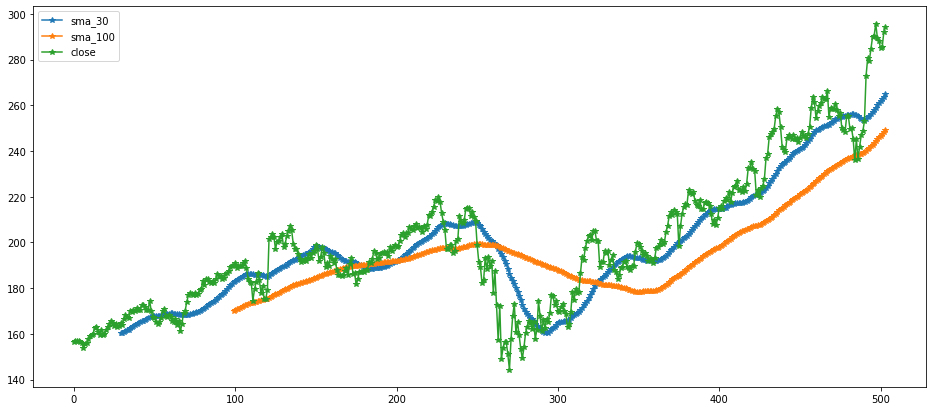

In [74]:
from ta.momentum import *
from ta.volatility import BollingerBands

rsi = rsi(df1.close, window =20)
sma = sma_indicator(df1.close, window =30)
smal = sma_indicator(df1.close, window =100)
ema= ema_indicator(df1.close, window =20)
bb_h = BollingerBands(df1.close, window=20, window_dev=2).bollinger_hband() 
bb_l = BollingerBands(df1.close, window=20, window_dev=2).bollinger_lband() 
bb_m = BollingerBands(df1.close, window=20, window_dev=2).bollinger_mavg() 

sma.plot(figsize =[16,7], legend = True, marker ="*")
smal.plot( legend = True,marker ="*")
#ema.plot(legend = True)
#rsi.plot(figsize =[10,10])
#bb_h.plot(legend = True)
#bb_l.plot(legend = True)
#bb_m.plot(legend = True)
df1.close.plot(legend = True,marker ="*")

In [53]:
df1['log'] = get_data(contract1, history, freq, side )['close'].apply(lambda x: math.log(x))
df2['log'] = get_data(contract2, history, freq, side )['close'].apply(lambda x: math.log(x))


In [55]:
df1.log

0      5.809583
1      5.775855
2      5.745084
3      5.741399
4      5.695448
         ...   
247    5.972893
248    5.972027
249    5.972256
250    5.967991
251    5.966224
Name: log, Length: 252, dtype: float64

<AxesSubplot:>

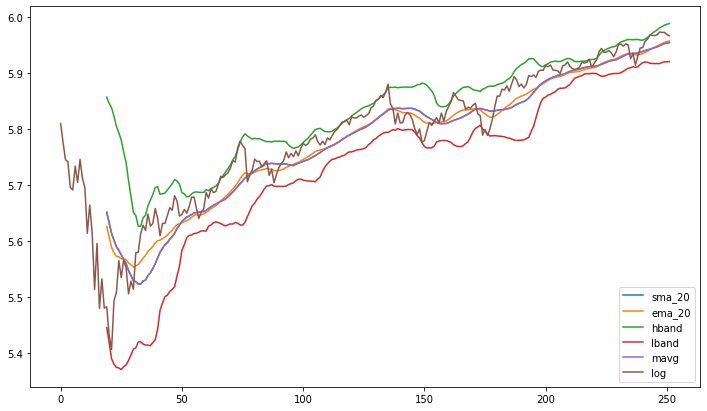

In [69]:
from ta.momentum import *
from ta.volatility import BollingerBands

rsi = rsi(df1.log, window =20)
sma = sma_indicator(df1.log, window =20)
ema= ema_indicator(df1.log, window =20)
bb_h = BollingerBands(df1.log, window=20, window_dev=2).bollinger_hband() 
bb_l = BollingerBands(df1.log, window=20, window_dev=2).bollinger_lband() 
bb_m = BollingerBands(df1.log, window=20, window_dev=2).bollinger_mavg() 

sma.plot(figsize =[12,7], legend = True)
ema.plot(legend = True)
#rsi.plot(figsize =[10,10])
bb_h.plot(legend = True)
bb_l.plot(legend = True)
bb_m.plot(legend = True)
df1.log.plot(legend = True)
